In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#plt.style.use('ggplot')

In [2]:
def get_ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1)/n
    return x, y

In [3]:
def get_clean_data(df_original):
    df = df_original.copy(deep=True)
    df['date'] =  pd.to_datetime(df['datetime'].apply(lambda x: x[:10]), format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['time'] = pd.to_datetime(df['datetime'].apply(lambda x: x[:19])).dt.time
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['datetime'].apply(lambda x: x[11:13]).astype(int)
    df['minute'] = df['datetime'].apply(lambda x: x[14:16]).astype(int)
    df['weekday'] = df['date'].dt.dayofweek
    clean_df = df[['date', 'year', 'month', 'day','weekday','time', 'hour', 'minute', 'value']]
    
    return clean_df

### 10-Minutes Demand

In [10]:
demanda_df = pd.read_csv('export_DemandaReal_2017-01-14_18-33.csv', encoding='latin1', delimiter=';')

In [11]:
demanda_time_df = get_clean_data(demanda_df)

In [12]:
#Remove those dates, hour 2 because they are duplicated: '2015-10-25';'2016-10-30'; '2014-10-26'
rows_remove = []
for date in ['2015-10-25','2016-10-30', '2014-10-26']:
    rows_remove = rows_remove + (demanda_time_df[(demanda_time_df['hour'] == 2) & (demanda_time_df['date'] == date)].iloc[-6:].index.tolist())

demanda_time_df.drop(demanda_time_df.index[rows_remove], inplace=True)

In [7]:
mean_hourly = demanda_time_df[['hour', 'minute', 'value']].groupby(['hour', 'minute']).mean()
mean_timely = demanda_time_df[['time', 'value']].groupby('time').mean()

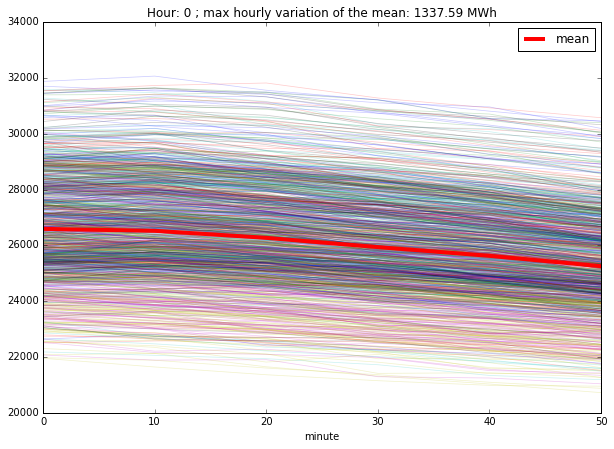

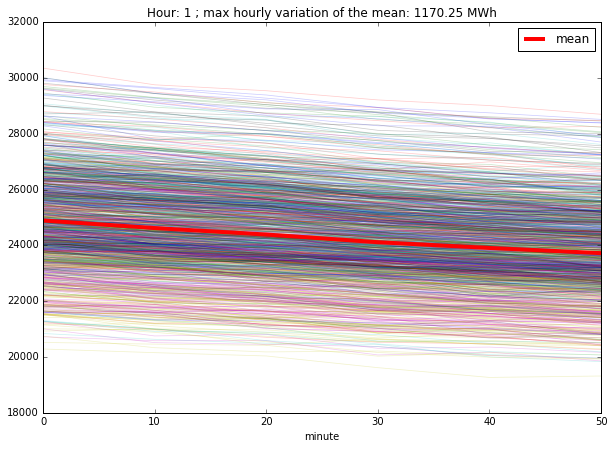

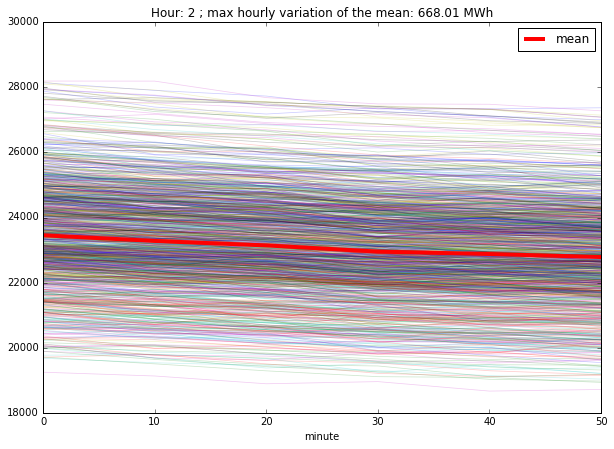

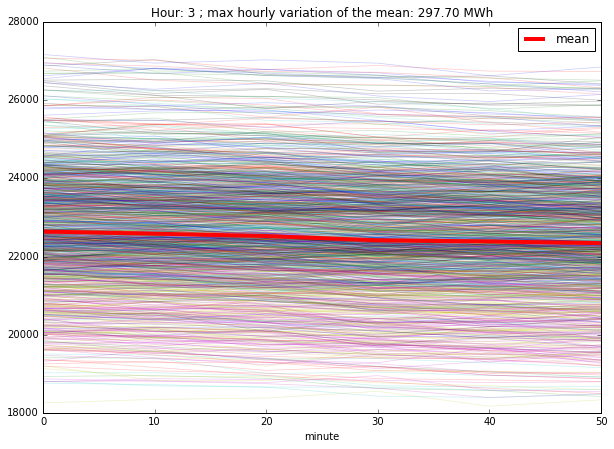

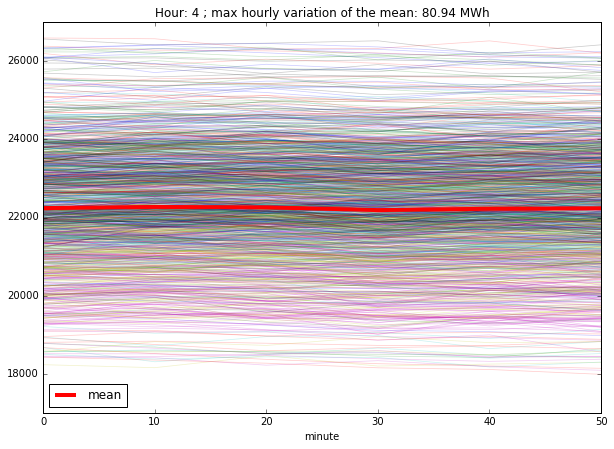

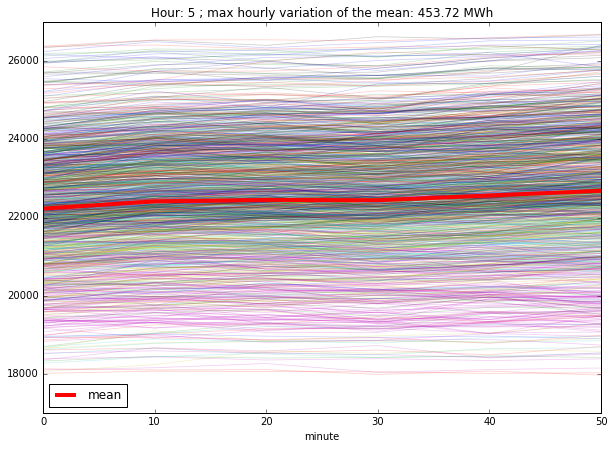

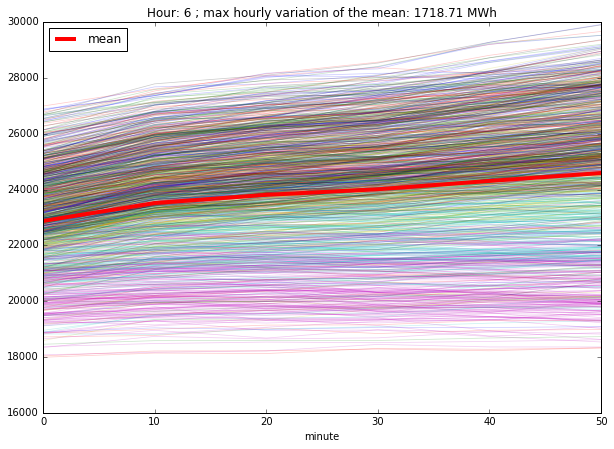

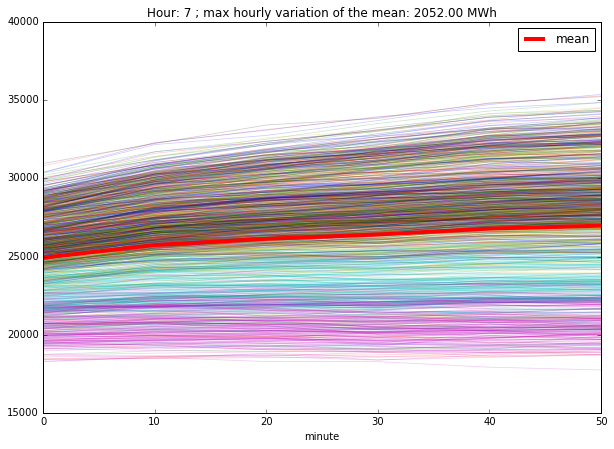

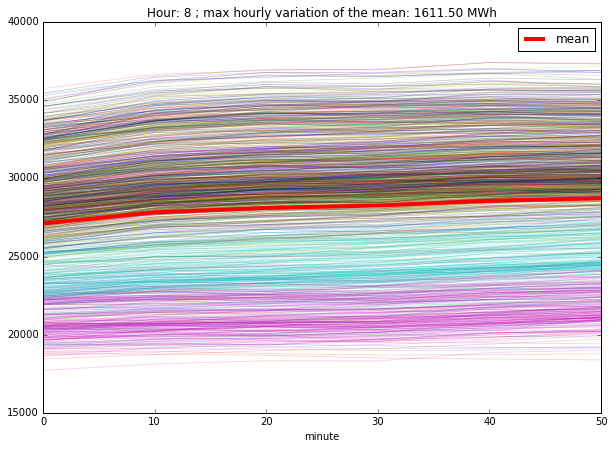

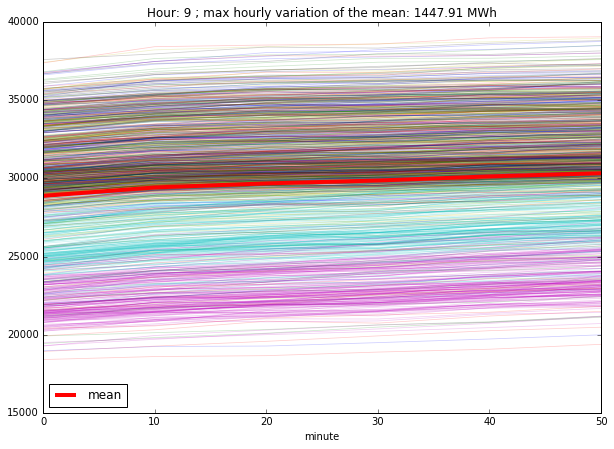

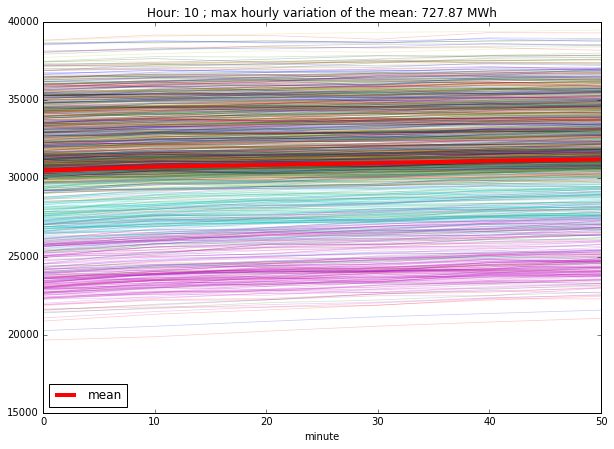

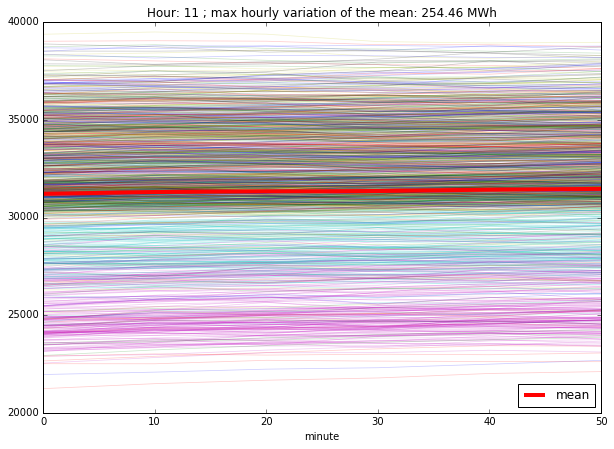

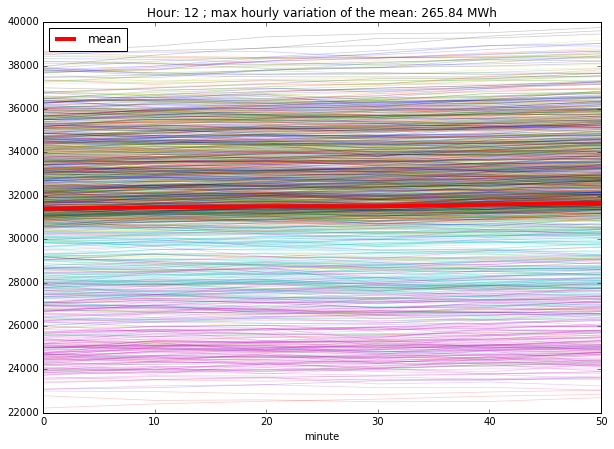

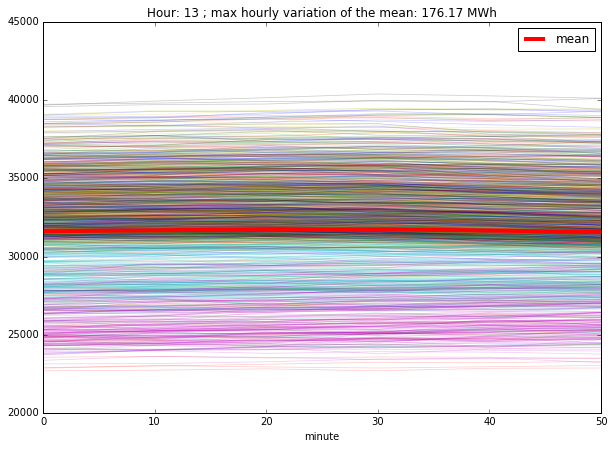

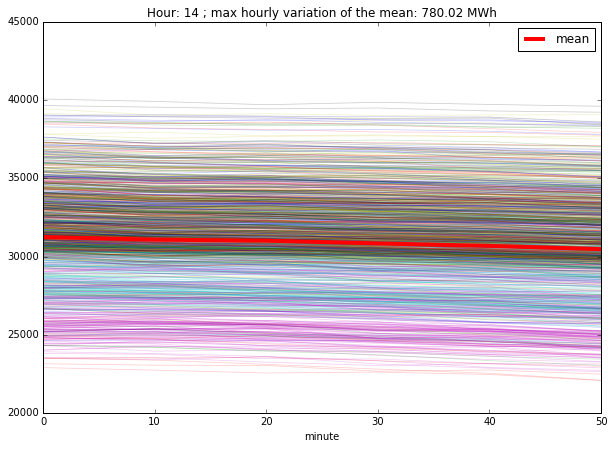

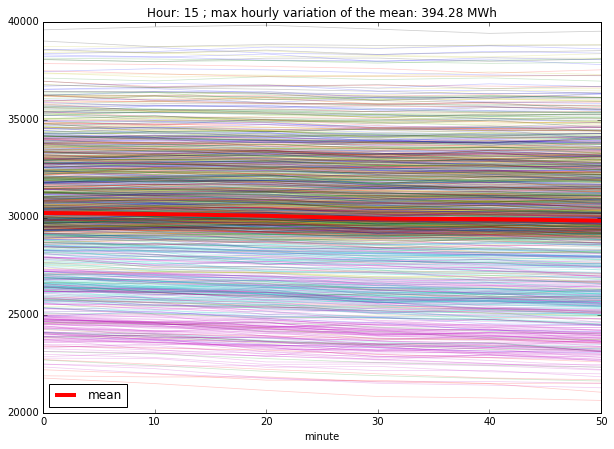

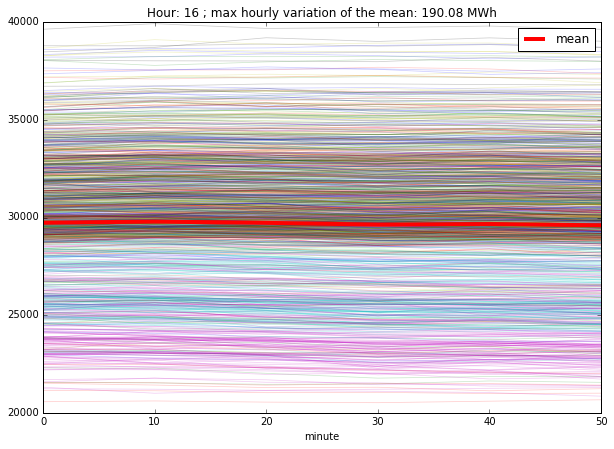

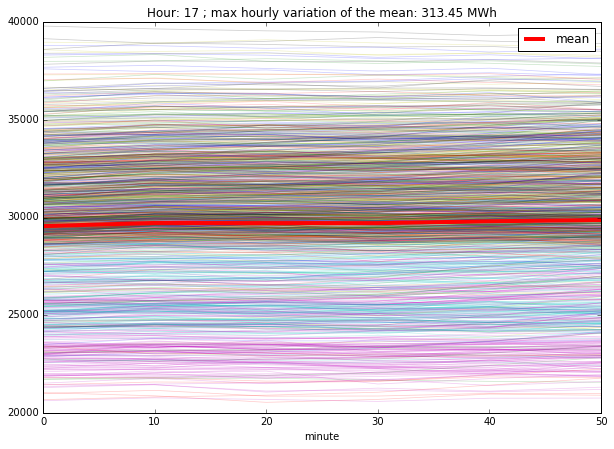

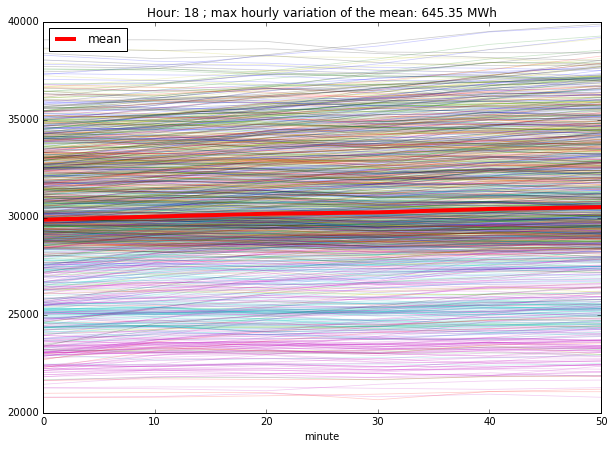

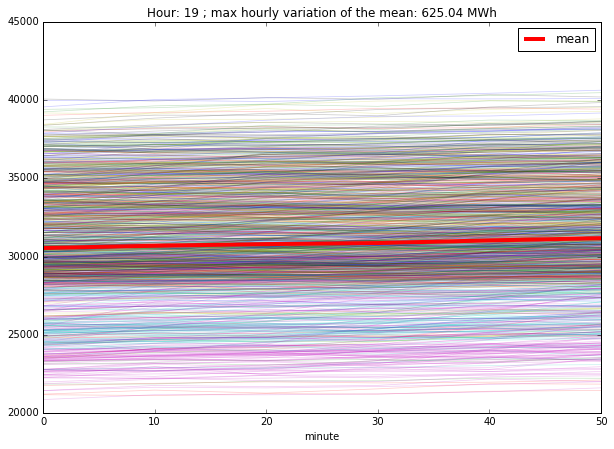

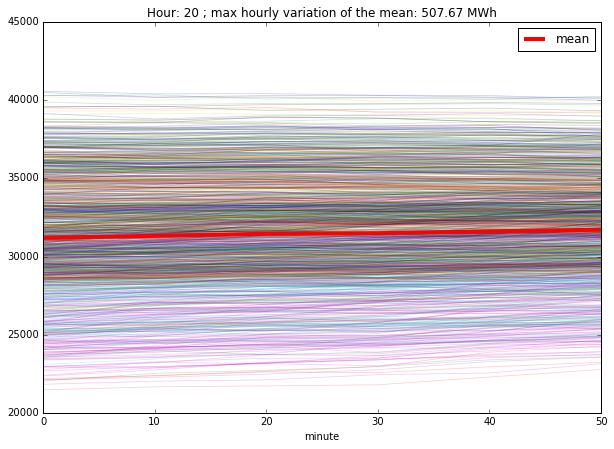

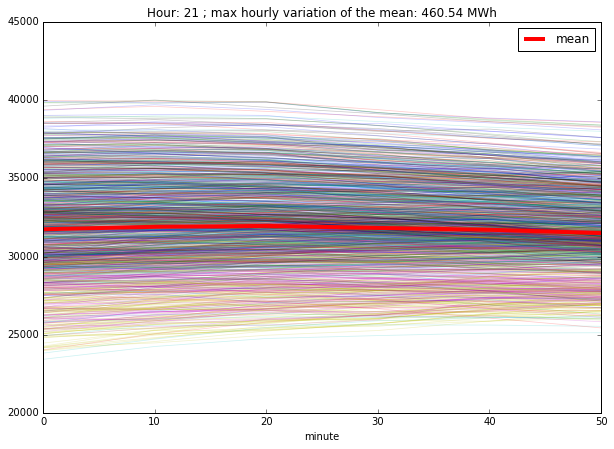

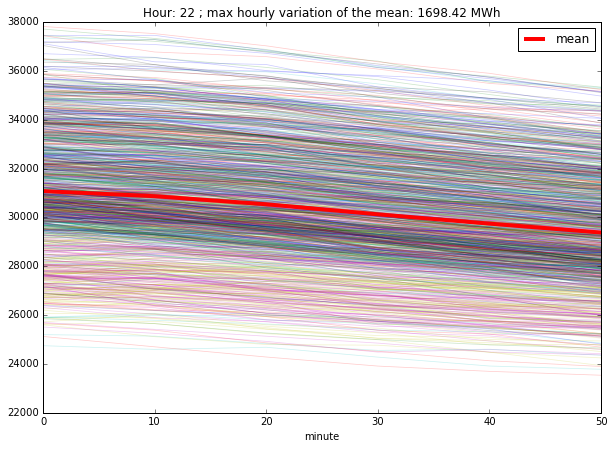

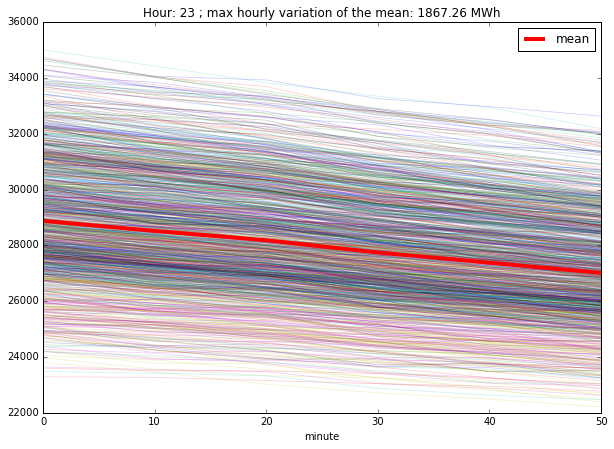

In [31]:
for hour in mean_hourly.index.levels[0].tolist():
    fig, axis = plt.subplots(1,1, figsize=(10,7))
    #Plot for each hour in 10-min basis, each day
    demanda_time_df[demanda_time_df['hour'] == hour].groupby(['minute', 'date'])[['value']].sum().unstack(-1).plot(ax=axis, legend=False, alpha=0.2, lw=0.75)
    #Plot the mean of all paths
    mean_hourly.loc[hour].rename(columns={'value':'mean'}).plot(ax=axis, lw=4.0, legend=True, color='red')
    max_variation = mean_hourly.loc[hour].max() - mean_hourly.loc[hour].min()
    #axis.legend(loc=0)
    axis.set_title('Hour: ' + str(hour) + ' ; max hourly variation of the mean: %.2f MWh' % max_variation)

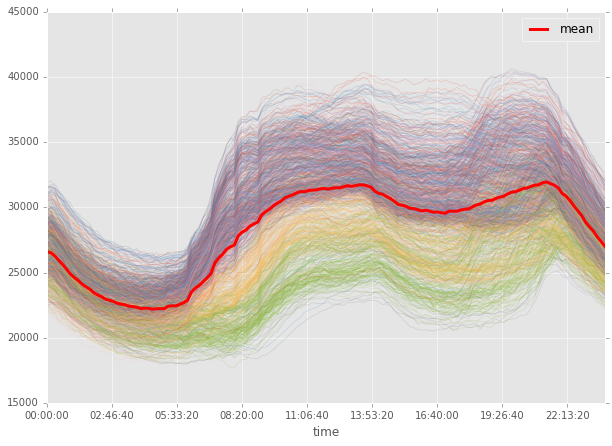

In [9]:
plt.style.use('ggplot')
fig, axis = plt.subplots(1,1, figsize=(10,7))
#Plot for each hour in 10-min basis, each day
demanda_time_df.groupby(['time', 'date'])[['value']].sum().unstack(-1).plot(ax=axis, legend=False, alpha=0.2, lw=0.75)
# #Plot the mean of all paths
mean_timely.rename(columns={'value':'mean'}).plot(ax=axis, lw=3.0, legend=True, color='red');
# max_variation = mean_hourly.loc[hour].max() - mean_hourly.loc[hour].min()
# #axis.legend(loc=0)

In [ ]:
plt.style.use('default')
% matplotlib inline
fig, axis = plt.subplots(1,1, figsize=(10,7))
#Plot for each hour in 10-min basis, each day
demanda_time_df.groupby(['time', 'date'])[['value']].sum().unstack(-1).plot(ax=axis, legend=False, alpha=0.2, lw=0.75)
# #Plot the mean of all paths
mean_timely.rename(columns={'value':'mean'}).plot(ax=axis, lw=3.0, legend=True, color='red');
# max_variation = mean_hourly.loc[hour].max() - mean_hourly.loc[hour].min()
# #axis.legend(loc=0)

### Secondary band price (€/MW)

In [4]:
secondary_band_price_df = pd.read_csv('export_PrecioBandaDeRegulaciónSecundaria_2017-01-15_19-11.csv', encoding='latin1', delimiter=';')

In [5]:
band_price_df = get_clean_data(secondary_band_price_df)

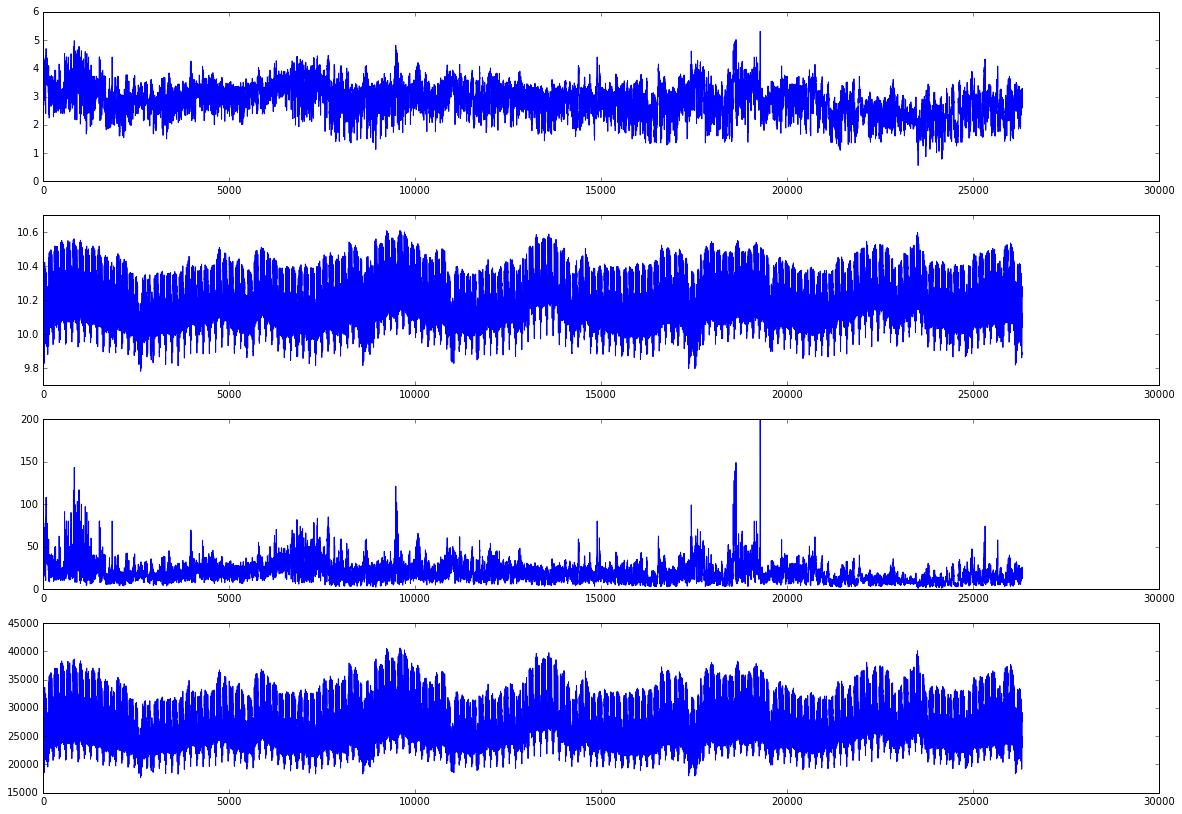

In [27]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(20,14))
ax0.plot(np.log1p(band_price_df['value'].values))
ax2.plot(band_price_df['value'].values)
ax1.plot(np.log1p(aa['value'].values))
ax3.plot(aa['value'].values);

In [10]:
year_weekday_hour_band_price = band_price_df[['year','weekday', 'hour', 'value']].groupby(['year', 'weekday', 'hour']).mean().unstack(-1)
year_weekday_hour_band_price.columns = year_weekday_hour_band_price.columns.droplevel(0)

In [13]:
aa = demanda_time_df[(demanda_time_df['date'] >= '2014-01-01') & (demanda_time_df['minute'] == 0)].reset_index().drop('index', axis=1)

In [14]:
aa['diff'] = aa['value'].diff(periods=1)

In [48]:
band_price_df['rolling_day'] = pd.rolling_mean(band_price_df['value'], 24)
aa['rolling_day'] = pd.rolling_mean(aa['value'], 24)

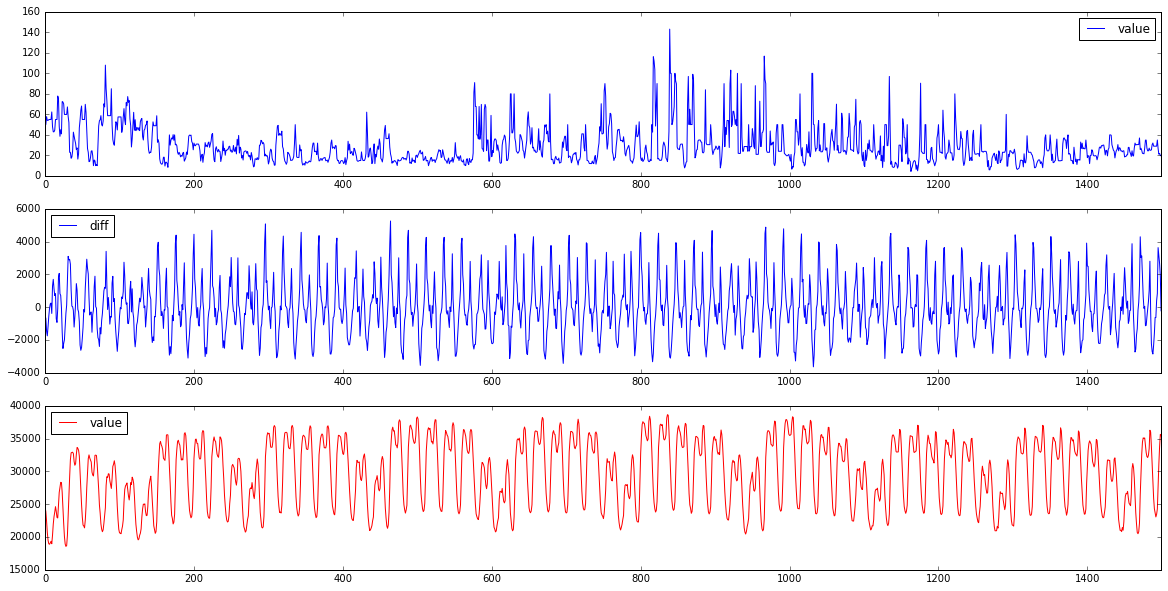

In [20]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,10))
band_price_df[['value']].iloc[:1500].plot(ax=ax0)
aa[['diff']].iloc[:1500].plot(ax=ax1, color='blue');
aa[['value']].iloc[:1500].plot(ax=ax2, color='red');

In [ ]:
for year in [2014, 2015, 2016]:
    fig, ax = plt.subplots(1,1, figsize=(18,7))
    #Use v_max, vmin to plot with same colors
    sns.heatmap(year_weekday_hour_band_price.loc[year], ax=ax, vmax=40, vmin=8)
    ax.set_title(year)

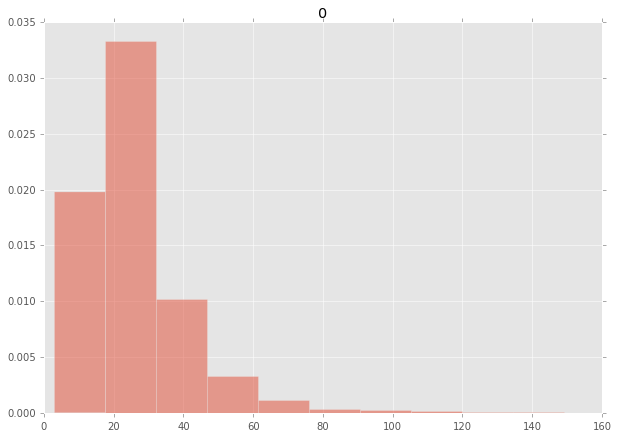

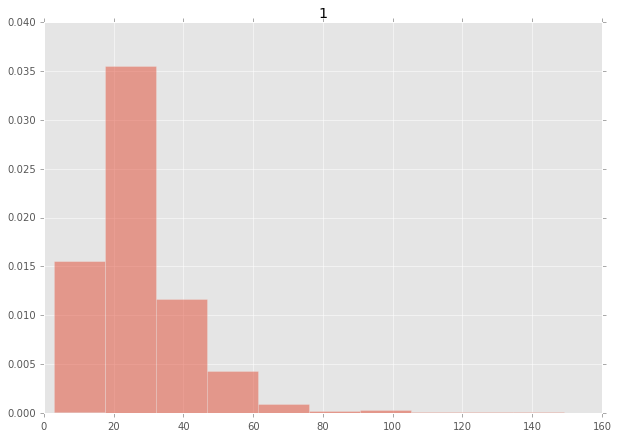

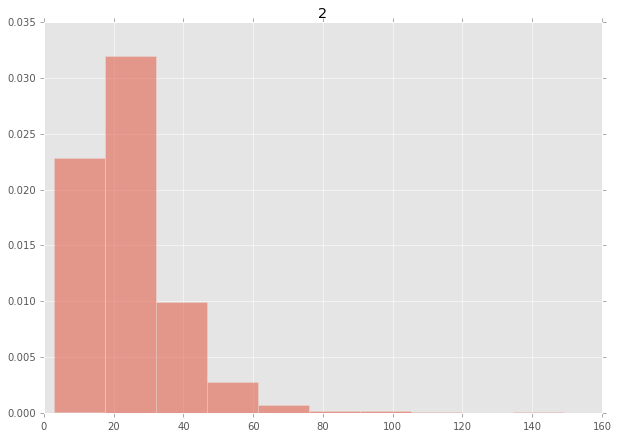

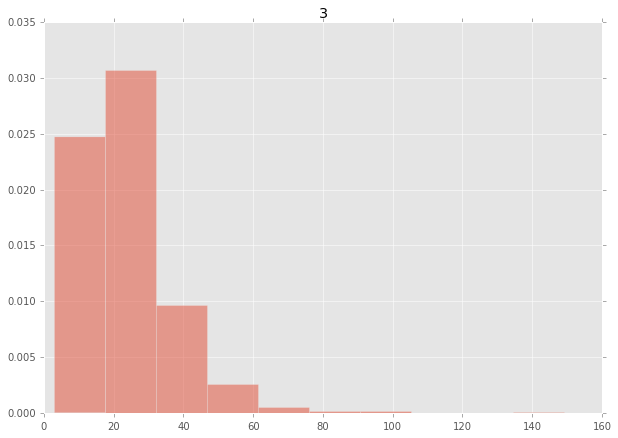

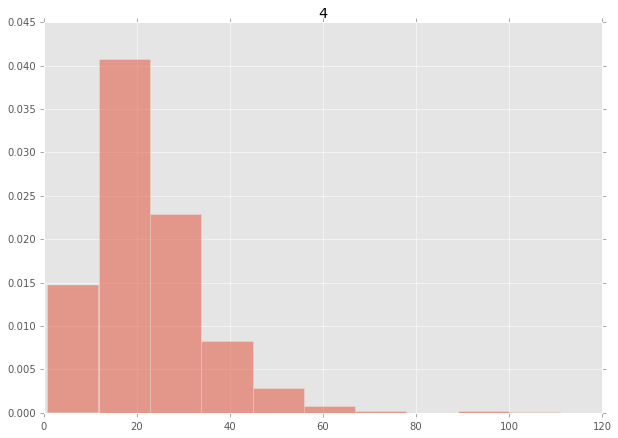

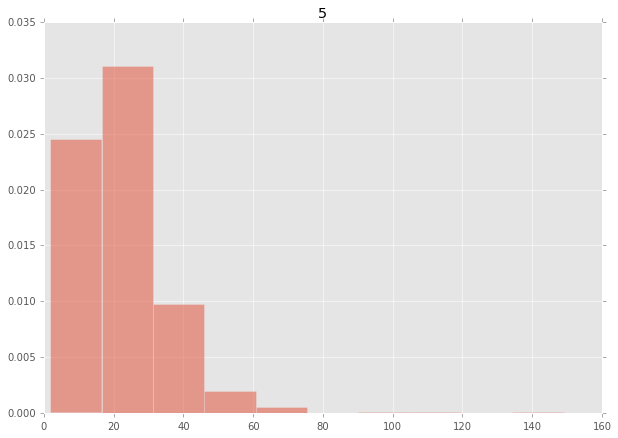

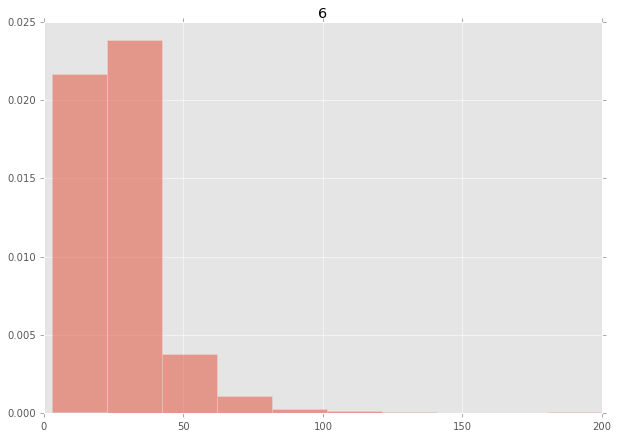

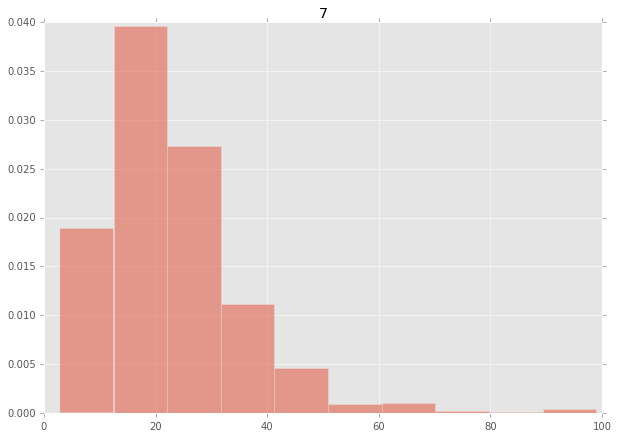

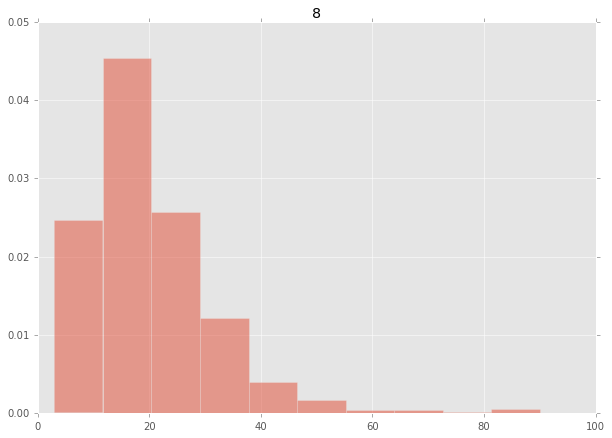

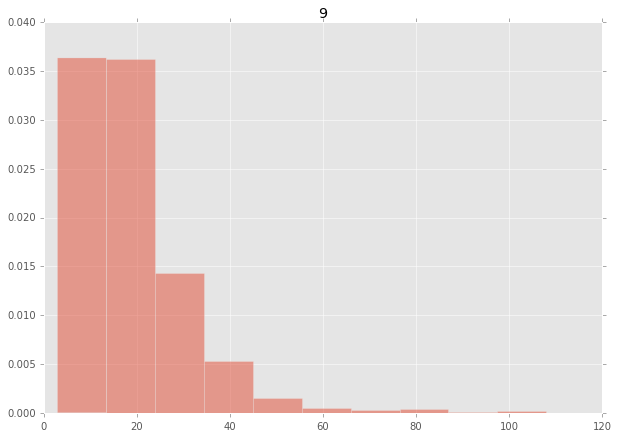

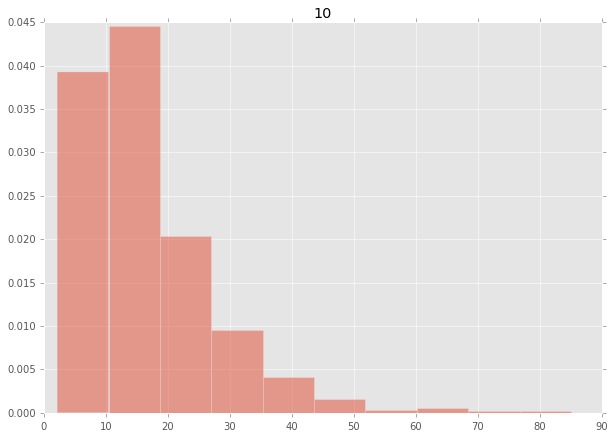

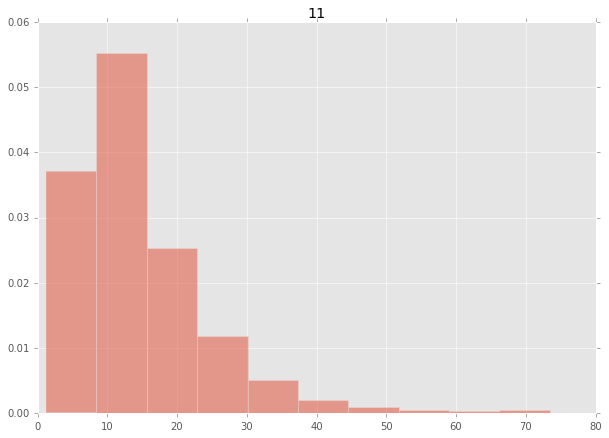

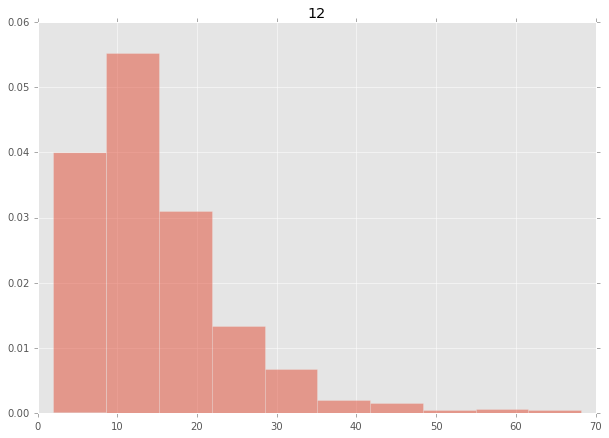

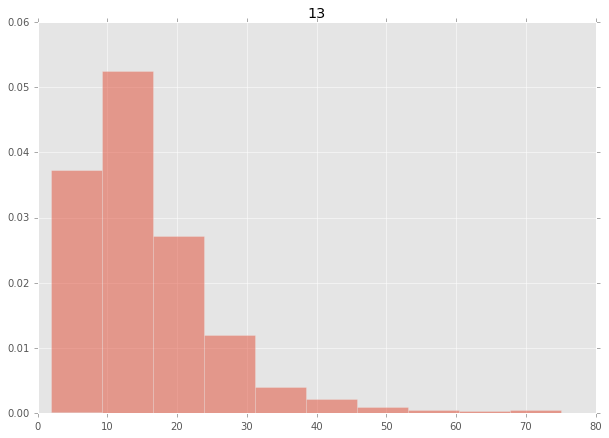

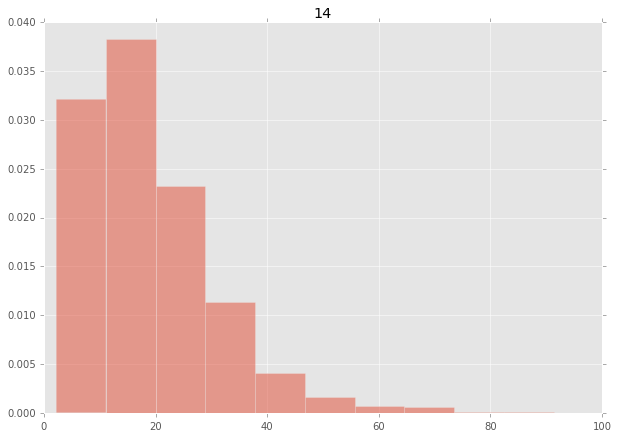

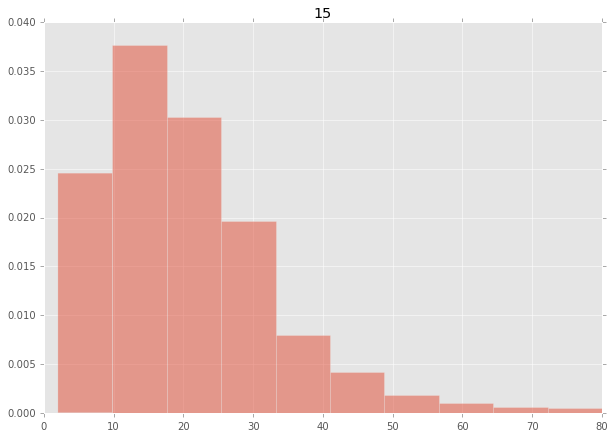

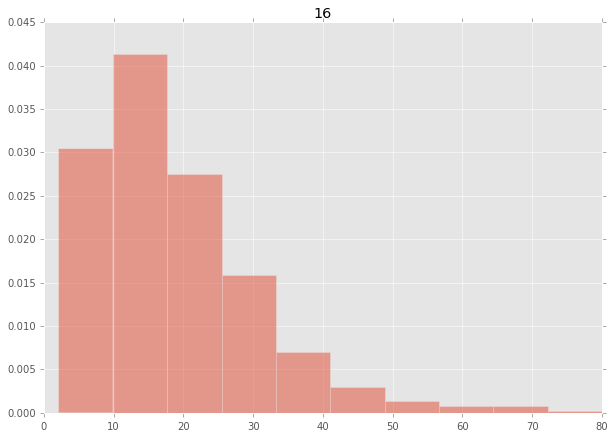

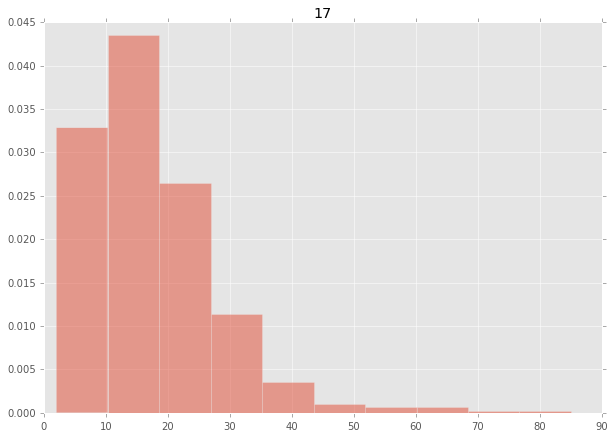

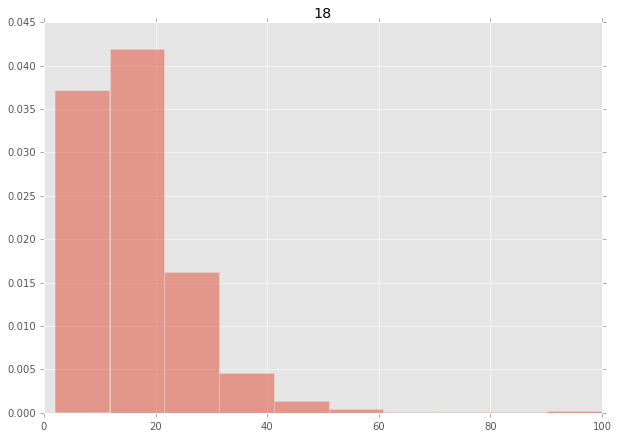

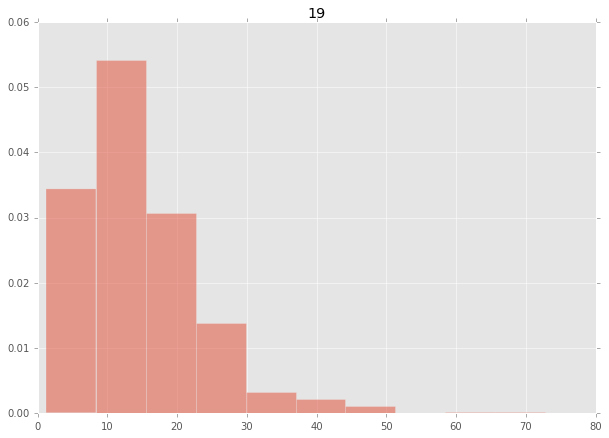

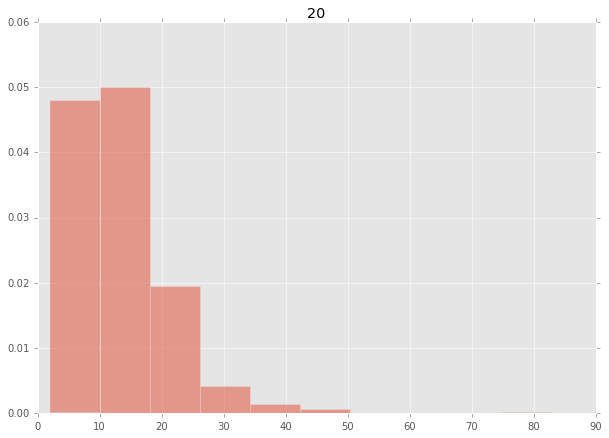

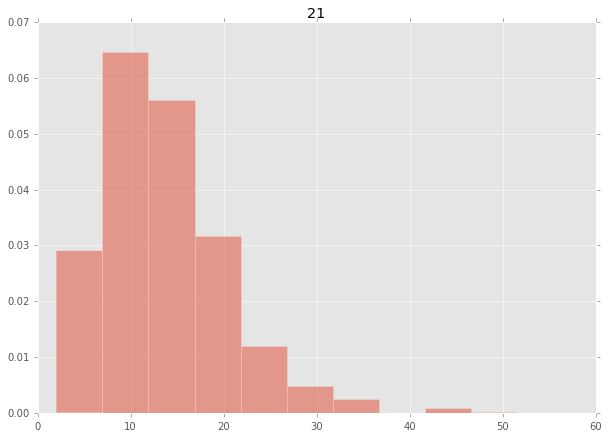

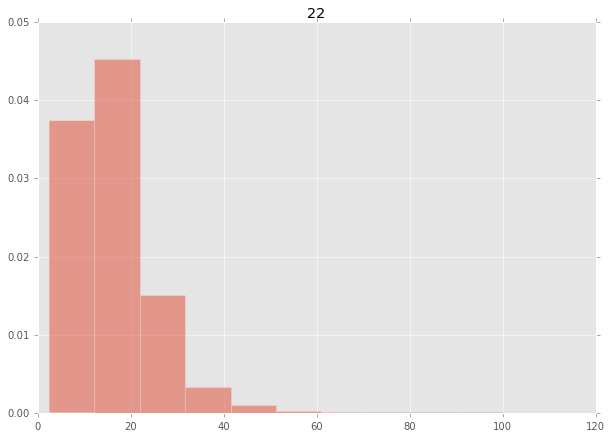

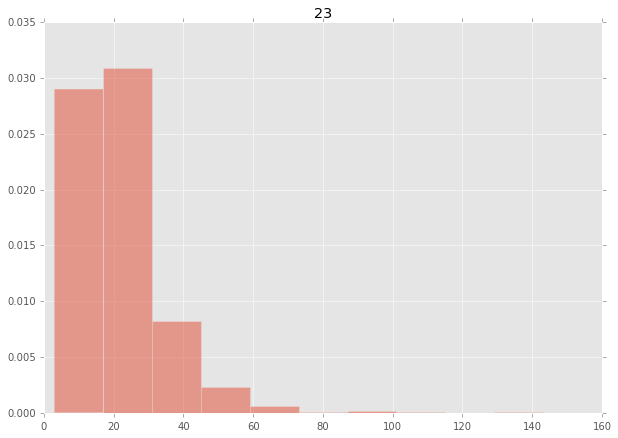

In [33]:
for hour in range(24):
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    band_price_df.set_index('time').loc[band_price_df.set_index('time').index[hour]][['value']].hist(alpha=0.5, ax=ax, normed=True)
    ax.set_title(hour)

In [ ]:
x, y = get_ecdf(band_price_df.set_index('time').loc[band_price_df.set_index('time').index[hour]]['value'].values)

In [ ]:
for hour in range(24):
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    x, y = get_ecdf(band_price_df.set_index('time').loc[band_price_df.set_index('time').index[hour]]['value'].values)
    ax.plot(x, y, marker='.', linestyle='none', label=hour, alpha=0.5, markersize=5)
    ax.legend(loc=0)
    ax.margins(0.02)
    ax.set_xlim([0,200])

In [ ]:
x, y = get_ecdf(band_price_df.set_index('time').loc[band_price_df.set_index('time').index[hour]]['value'].values)

In [ ]:
a = np.random.random(len(y))

In [ ]:
np.random.choice(x, p=y)

In [ ]:
plt.hist(x, normed=True)

In [ ]:
x

In [ ]:
norm_x = [float(i)/np.sum(x) for i in x]

In [ ]:
np.array(norm_x).max()

In [6]:
hour = 20

In [16]:
x = band_price_df.set_index('time').loc[band_price_df.set_index('time').index[hour]]['value'].value_counts().index.values

In [17]:
p= (band_price_df.set_index('time').loc[band_price_df.set_index('time').index[hour]]['value'].value_counts() / len(band_price_df.set_index('time').loc[band_price_df.set_index('time').index[hour]]['value'])).values

In [18]:
prueba_x = np.random.choice(x, size=100, p=p)

In [19]:
x, y = get_ecdf(band_price_df.set_index('time').loc[band_price_df.set_index('time').index[hour]]['value'].values)

In [20]:
x_prueba, y_prueba = get_ecdf(prueba_x)

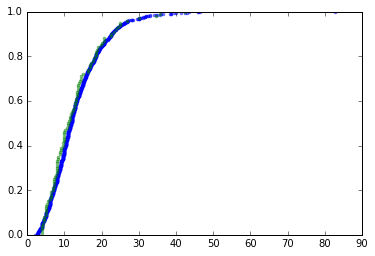

In [21]:
_ = plt.plot(x,y, marker='.', linestyle='none', alpha=0.5)
_ = plt.plot(x_prueba, y_prueba, marker='.', linestyle='none', alpha=0.5)

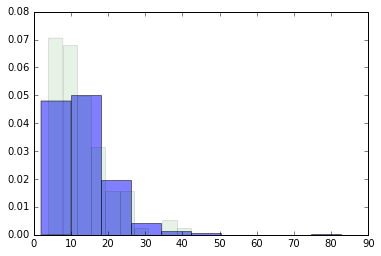

In [22]:
_ = plt.hist(x, alpha=0.5, normed=True)
_ = plt.hist(x_prueba, alpha=0.1, normed=True)

In [32]:
a= band_price_df[['date','hour','value']]

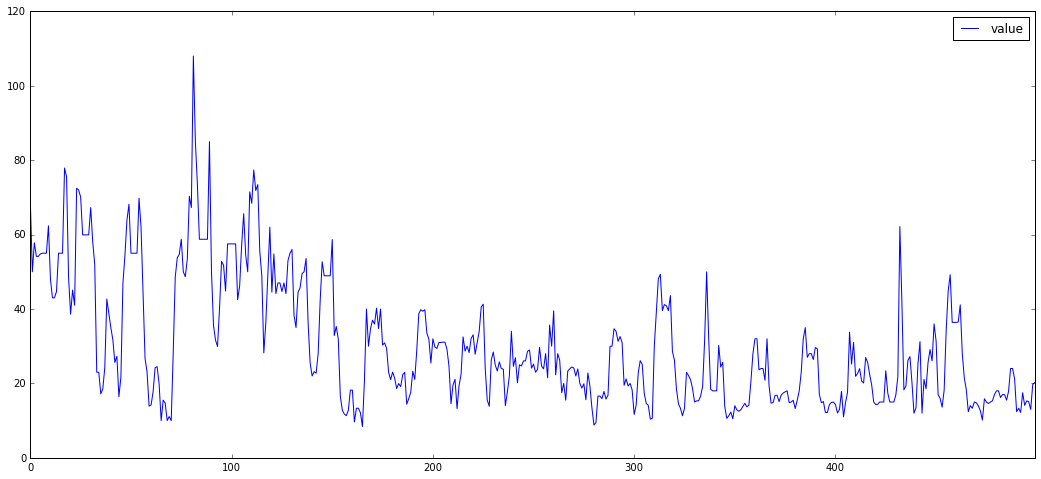

In [27]:
a[a['date'].dt.year == 2014].iloc[:500][['value']].plot(figsize=(18,8))

### Secondary reserve price ($€/MWh$)

In [4]:
secundaria_precio = pd.read_csv('export_PrecioDeRegulaciónSecundariaBajar_2017-01-08_13-53.csv', encoding='latin1', delimiter=';')

In [7]:
secundaria_precio.head(2)

id                                    name  geoid  geoname  value  \
0  683  Precio de RegulaciÃ³n Secundaria bajar    NaN      NaN    0.0   
1  683  Precio de RegulaciÃ³n Secundaria bajar    NaN      NaN    0.0   

                    datetime  
0  2014-01-01T00:00:00+01:00  
1  2014-01-01T01:00:00+01:00

In [9]:
reserva_precio = get_clean_data(secundaria_precio)

In [49]:
reserva_precio[reserva_precio['value'] == 0]

date  year  month  day  weekday      time  hour  minute  value
0     2014-01-01  2014      1    1        2  00:00:00     0       0    0.0
1     2014-01-01  2014      1    1        2  01:00:00     1       0    0.0
3     2014-01-01  2014      1    1        2  03:00:00     3       0    0.0
4     2014-01-01  2014      1    1        2  04:00:00     4       0    0.0
5     2014-01-01  2014      1    1        2  05:00:00     5       0    0.0
6     2014-01-01  2014      1    1        2  06:00:00     6       0    0.0
7     2014-01-01  2014      1    1        2  07:00:00     7       0    0.0
8     2014-01-01  2014      1    1        2  08:00:00     8       0    0.0
9     2014-01-01  2014      1    1        2  09:00:00     9       0    0.0
10    2014-01-01  2014      1    1        2  10:00:00    10       0    0.0
11    2014-01-01  2014      1    1        2  11:00:00    11       0    0.0
12    2014-01-01  2014      1    1        2  12:00:00    12       0    0.0
16    2014-01-01  2014      1    1        2  16:00:00    16       0    0.0
17    2014-01-01  2014      1    1        2  17:00:00    17       0    0.0
22    2014-01-01  2014      1    1        2  22:00:00    22       0    0.0
23    2014-01-01  2014      1    1        2  23:00:00    23       0    0.0
24    2014-01-02  2014      1    2        3  00:00:00     0       0    0.0
25    2014-01-02  2014      1    2        3  03:00:00     3       0    0.0
26    2014-01-02  2014      1    2        3  04:00:00     4       0    0.0
35    2014-01-03  2014      1    3        4  01:00:00     1       0    0.0
36    2014-01-03  2014      1    3        4  04:00:00     4       0    0.0
39    2014-01-03  2014      1    3        4  11:00:00    11       0    0.0
41    2014-01-03  2014      1    3        4  13:00:00    13       0    0.0
43    2014-01-03  2014      1    3        4  16:00:00    16       0    0.0
49    2014-01-03  2014      1    3        4  23:00:00    23       0    0.0
50    2014-01-04  2014      1    4        5  00:00:00     0       0    0.0
51    2014-01-04  2014      1    4        5  01:00:00     1       0    0.0
52    2014-01-04  2014      1    4        5  04:00:00     4       0    0.0
53    2014-01-04  2014      1    4        5  07:00:00     7       0    0.0
54    2014-01-04  2014      1    4        5  08:00:00     8       0    0.0
...          ...   ...    ...  ...      ...       ...   ...     ...    ...
15734 2016-05-19  2016      5   19        3  22:00:00    22       0    0.0
15763 2016-05-22  2016      5   22        6  06:00:00     6       0    0.0
15766 2016-05-22  2016      5   22        6  12:00:00    12       0    0.0
15767 2016-05-22  2016      5   22        6  13:00:00    13       0    0.0
15768 2016-05-22  2016      5   22        6  14:00:00    14       0    0.0
15769 2016-05-22  2016      5   22        6  19:00:00    19       0    0.0
15873 2016-05-29  2016      5   29        6  09:00:00     9       0    0.0
15877 2016-05-29  2016      5   29        6  16:00:00    16       0    0.0
16244 2016-06-19  2016      6   19        6  06:00:00     6       0    0.0
16245 2016-06-19  2016      6   19        6  07:00:00     7       0    0.0
16246 2016-06-19  2016      6   19        6  08:00:00     8       0    0.0
16247 2016-06-19  2016      6   19        6  09:00:00     9       0    0.0
16248 2016-06-19  2016      6   19        6  10:00:00    10       0    0.0
16494 2016-07-03  2016      7    3        6  06:00:00     6       0    0.0
17133 2016-08-07  2016      8    7        6  07:00:00     7       0    0.0
17181 2016-08-10  2016      8   10        2  03:00:00     3       0    0.0
18710 2016-10-23  2016     10   23        6  03:00:00     3       0    0.0
18711 2016-10-23  2016     10   23        6  04:00:00     4       0    0.0
18712 2016-10-23  2016     10   23        6  05:00:00     5       0    0.0
19007 2016-11-06  2016     11    6        6  03:00:00     3       0    0.0
19008 2016-11-06  2016     11    6        6  04:00:00     4       0    0.0
19009 2016-11-06  2016     11    6   

In [46]:
eu_b[eu_b['value'] == 0].shape

(6137, 9)

In [36]:
energia_utilizada = pd.read_csv('export_EnergíaUtilizadaDeRegulaciónSecundariaBajar_2017-01-08_13-54.csv', encoding='latin1', delimiter =';')

In [38]:
eu_b = get_clean_data(energia_utilizada)

In [39]:
eu_b[['value']].iloc[800:1700].plot(figsize=(18,8));

date  year  month  day  weekday      time  hour  minute  value
0     2014-01-01  2014      1    1        2  00:00:00     0       0  209.8
1     2014-01-01  2014      1    1        2  01:00:00     1       0    7.2
2     2014-01-01  2014      1    1        2  02:00:00     2       0    5.9
3     2014-01-01  2014      1    1        2  03:00:00     3       0  217.5
4     2014-01-01  2014      1    1        2  04:00:00     4       0  165.9
5     2014-01-01  2014      1    1        2  05:00:00     5       0  409.5
6     2014-01-01  2014      1    1        2  06:00:00     6       0    1.6
7     2014-01-01  2014      1    1        2  07:00:00     7       0   33.2
8     2014-01-01  2014      1    1        2  08:00:00     8       0   68.9
9     2014-01-01  2014      1    1        2  09:00:00     9       0    0.7
10    2014-01-01  2014      1    1        2  10:00:00    10       0    5.8
11    2014-01-01  2014      1    1        2  11:00:00    11       0    6.6
12    2014-01-01  2014      1    1        2  12:00:00    12       0    6.2
13    2014-01-01  2014      1    1        2  13:00:00    13       0    6.2
14    2014-01-01  2014      1    1        2  14:00:00    14       0    6.0
15    2014-01-01  2014      1    1        2  15:00:00    15       0    3.4
16    2014-01-01  2014      1    1        2  16:00:00    16       0  277.9
17    2014-01-01  2014      1    1        2  17:00:00    17       0   42.4
18    2014-01-01  2014      1    1        2  18:00:00    18       0    5.3
19    2014-01-01  2014      1    1        2  19:00:00    19       0  324.5
20    2014-01-01  2014      1    1        2  20:00:00    20       0    7.3
21    2014-01-01  2014      1    1        2  21:00:00    21       0   17.7
22    2014-01-01  2014      1    1        2  22:00:00    22       0   10.0
23    2014-01-01  2014      1    1        2  23:00:00    23       0  460.6
24    2014-01-02  2014      1    2        3  00:00:00     0       0   55.2
25    2014-01-02  2014      1    2        3  01:00:00     1       0    0.0
26    2014-01-02  2014      1    2        3  02:00:00     2       0    0.0
27    2014-01-02  2014      1    2        3  03:00:00     3       0   99.9
28    2014-01-02  2014      1    2        3  04:00:00     4       0    8.0
29    2014-01-02  2014      1    2        3  05:00:00     5       0    0.0
...          ...   ...    ...  ...      ...       ...   ...     ...    ...
26455 2017-01-07  2017      1    7        5  07:00:00     7       0    2.3
26456 2017-01-07  2017      1    7        5  08:00:00     8       0    4.7
26457 2017-01-07  2017      1    7        5  09:00:00     9       0   21.1
26458 2017-01-07  2017      1    7        5  10:00:00    10       0   30.7
26459 2017-01-07  2017      1    7        5  11:00:00    11       0    0.8
26460 2017-01-07  2017      1    7        5  12:00:00    12       0   94.5
26461 2017-01-07  2017      1    7        5  13:00:00    13       0   10.0
26462 2017-01-07  2017      1    7        5  14:00:00    14       0    0.3
26463 2017-01-07  2017      1    7        5  15:00:00    15       0    0.2
26464 2017-01-07  2017      1    7        5  16:00:00    16       0    5.3
26465 2017-01-07  2017      1    7        5  17:00:00    17       0   37.3
26466 2017-01-07  2017      1    7        5  18:00:00    18       0  180.5
26467 2017-01-07  2017      1    7        5  19:00:00    19       0   13.0
26468 2017-01-07  2017      1    7        5  20:00:00    20       0   16.5
26469 2017-01-07  2017      1    7        5  21:00:00    21       0   39.5
26470 2017-01-07  2017      1    7        5  22:00:00    22       0  180.6
26471 2017-01-07  2017      1    7        5  23:00:00    23       0  391.8
26472 2017-01-08  2017      1    8        6  00:00:00     0       0    0.0
26473 2017-01-08  2017      1    8        6  01:00:00     1       0    0.0
26474 2017-01-08  2017      1    8        6  02:00:00     2       0    0.0
26475 2017-01-08  2017      1    8        6  03:00:00     3       0    0.0
26476 2017-01-08  2017      1    8   